<a href="https://colab.research.google.com/github/fojeda/truncated_distribution/blob/main/Truncated_Weibull_(Transformed)_PDF_and_CDF_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import torch
from torch.distributions import Distribution, Weibull, Uniform, TransformedDistribution
from torch.distributions import constraints
from torch.distributions.transforms import Transform
from torch.distributions.utils import broadcast_all
import matplotlib.pyplot as plt
import numpy as np

## Truncated Distribution class

In [30]:
# --- Original TruncatedDistribution class ---
class TruncatedDistribution(Distribution):
    """
    A generic truncated distribution class for PyTorch.
    Subclasses `torch.distributions.Distribution` directly.
    """
    arg_constraints = {
        'lower_bound': constraints.real,
        'upper_bound': constraints.real
    }

    def __init__(self, base_distribution: Distribution, lower_bound: torch.Tensor, upper_bound: torch.Tensor, validate_args=None):
        if not isinstance(base_distribution, Distribution):
            raise TypeError("base_distribution must be an instance of torch.distributions.Distribution")

        if not (hasattr(base_distribution, 'cdf') and hasattr(base_distribution, 'log_prob')):
             raise NotImplementedError(
                 f"Base distribution {type(base_distribution).__name__} must implement "
                 "`cdf` and `log_prob` methods for truncation."
             )

        param_dtype = torch.float32
        param_device = 'cpu'
        # Iterate through common parameter names to find dtype and device
        for param_name in ['loc', 'scale', 'rate', 'concentration1', 'concentration0', 'probs', 'shape', 'concentration']:
            if hasattr(base_distribution, param_name):
                param_tensor = getattr(base_distribution, param_name)
                if isinstance(param_tensor, torch.Tensor):
                    param_dtype = param_tensor.dtype
                    param_device = param_tensor.device
                    break

        lower_bound = torch.as_tensor(lower_bound, dtype=param_dtype, device=param_device)
        upper_bound = torch.as_tensor(upper_bound, dtype=param_dtype, device=param_device)

        try:
            common_shape = base_distribution.batch_shape
            common_shape = torch.broadcast_shapes(common_shape, lower_bound.shape, upper_bound.shape)
            self.base_distribution = base_distribution.expand(common_shape)
            self.lower_bound, self.upper_bound = broadcast_all(lower_bound, upper_bound)

        except RuntimeError as e:
            raise ValueError(
                f"Bounds {lower_bound.shape} and {upper_bound.shape} are not broadcastable "
                f"with base_distribution batch_shape {base_distribution.batch_shape}. Error: {e}"
            )

        if not torch.all(self.lower_bound < self.upper_bound):
            raise ValueError("lower_bound must be strictly less than upper_bound for a valid truncated interval.")

        cdf_upper = self.base_distribution.cdf(self.upper_bound)
        cdf_lower = self.base_distribution.cdf(self.lower_bound)

        self.normalization_constant = (cdf_upper - cdf_lower).clamp_min(torch.finfo(cdf_upper.dtype).tiny)
        self.log_normalization_constant = self.normalization_constant.log()

        super().__init__(batch_shape=self.base_distribution.batch_shape,
                         event_shape=self.base_distribution.event_shape,
                         validate_args=validate_args)

    @property
    def support(self):
        return constraints.real

    def log_prob(self, value: torch.Tensor) -> torch.Tensor:
        # Determine the correct dtype and device from base_distribution's parameters.
        # This generic approach handles various distribution types more robustly.
        if hasattr(self.base_distribution, 'scale'): # Common for Weibull, Normal, Cauchy
            data_dtype = self.base_distribution.scale.dtype
            data_device = self.base_distribution.scale.device
        elif hasattr(self.base_distribution, 'rate'): # For Exponential
            data_dtype = self.base_distribution.rate.dtype
            data_device = self.base_distribution.rate.device
        elif hasattr(self.base_distribution, 'concentration1'): # For Beta
            data_dtype = self.base_distribution.concentration1.dtype
            data_device = self.base_distribution.concentration1.device
        else: # Fallback
            data_dtype = torch.float32
            data_device = 'cpu'

        value = torch.as_tensor(value, dtype=data_dtype, device=data_device)

        try:
            value_b, lower_b, upper_b = broadcast_all(value, self.lower_bound, self.upper_bound)
        except RuntimeError as e:
            raise ValueError(f"Observed value shape {value.shape} not broadcastable with distribution bounds shapes. Error: {e}")

        log_probs = torch.full_like(value_b, -float('inf'))

        within_bounds_mask = (value_b >= lower_b) & (value_b <= upper_b)

        log_prob_base = self.base_distribution.log_prob(value_b)

        log_norm_const_expanded, _ = broadcast_all(self.log_normalization_constant, log_prob_base)

        log_probs_within_bounds = log_prob_base - log_norm_const_expanded

        log_probs = torch.where(within_bounds_mask, log_probs_within_bounds, log_probs)

        return log_probs

    def cdf(self, value: torch.Tensor) -> torch.Tensor:
        """
        Computes the cumulative distribution function (CDF) for the truncated distribution.

        Args:
            value (torch.Tensor): The value(s) for which to compute the CDF.

        Returns:
            torch.Tensor: The CDF value for each input.
        """
        # Determine the correct dtype and device from base_distribution's parameters.
        if hasattr(self.base_distribution, 'scale'):
            data_dtype = self.base_distribution.scale.dtype
            data_device = self.base_distribution.scale.device
        elif hasattr(self.base_distribution, 'rate'):
            data_dtype = self.base_distribution.rate.dtype
            data_device = self.base_distribution.rate.device
        elif hasattr(self.base_distribution, 'concentration1'):
            data_dtype = self.base_distribution.concentration1.dtype
            data_device = self.base_distribution.concentration1.device
        else:
            data_dtype = torch.float32
            data_device = 'cpu'

        value = torch.as_tensor(value, dtype=data_dtype, device=data_device)

        # Broadcast value with self.lower_bound and self.upper_bound
        value_b, lower_b, upper_b = broadcast_all(value, self.lower_bound, self.upper_bound)

        cdf_val = torch.zeros_like(value_b)

        # Mask for values within the truncation bounds [lower_b, upper_b]
        within_bounds_mask = (value_b >= lower_b) & (value_b <= upper_b)

        # Calculate base CDFs at the value and lower bound
        cdf_at_value_base = self.base_distribution.cdf(value_b)
        cdf_at_lower_base = self.base_distribution.cdf(lower_b)

        # The truncated CDF formula: (F_B(x) - F_B(lower)) / (F_B(upper) - F_B(lower))
        # Use normalization_constant which is (F_B(upper) - F_B(lower))
        truncated_cdf_within_bounds = (cdf_at_value_base - cdf_at_lower_base) / self.normalization_constant

        # Apply results based on masks
        # If value < lower_b, cdf_val remains 0 (initialized as such)
        # If value > upper_b, cdf_val is 1
        cdf_val = torch.where(value_b > upper_b, torch.ones_like(cdf_val), cdf_val)
        # For values within bounds, apply the calculated truncated_cdf_within_bounds
        cdf_val = torch.where(within_bounds_mask, truncated_cdf_within_bounds, cdf_val)

        return cdf_val

    def sample(self, sample_shape=torch.Size()):
        full_sample_shape = sample_shape + self.base_distribution.batch_shape + self.base_distribution.event_shape

        # Determine the correct dtype and device for samples
        if hasattr(self.base_distribution, 'scale'):
            sample_dtype = self.base_distribution.scale.dtype
            sample_device = self.base_distribution.scale.device
        elif hasattr(self.base_distribution, 'rate'):
            sample_dtype = self.base_distribution.rate.dtype
            sample_device = self.base_distribution.rate.device
        elif hasattr(self.base_distribution, 'concentration1'):
            sample_dtype = self.base_distribution.concentration1.dtype
            sample_device = self.base_distribution.concentration1.device
        else:
            sample_dtype = torch.float32
            sample_device = 'cpu'

        samples = torch.empty(full_sample_shape, dtype=sample_dtype, device=sample_device)

        num_remaining = samples.numel()
        mask_remaining = torch.ones(full_sample_shape, dtype=torch.bool, device=samples.device)

        max_attempts = 10000
        attempts = 0

        while num_remaining > 0 and attempts < max_attempts:
            current_samples_full_batch = self.base_distribution.sample(sample_shape)

            expanded_lower_bound = self.lower_bound.expand(current_samples_full_batch.shape)
            expanded_upper_bound = self.upper_bound.expand(current_samples_full_batch.shape)

            within_bounds = (current_samples_full_batch >= expanded_lower_bound) & \
                            (current_samples_full_batch <= expanded_upper_bound)

            samples[mask_remaining & within_bounds] = current_samples_full_batch[mask_remaining & within_bounds]

            mask_remaining[mask_remaining & within_bounds] = False

            num_remaining = mask_remaining.sum().item()
            attempts += 1

        if num_remaining > 0:
            print(f"Warning (TruncatedDistribution Direct): Could not sample all {num_remaining} values within bounds after {max_attempts} attempts. "
                  f"Filling remaining samples with lower_bound. Consider increasing max_attempts or checking bounds/base_distribution.")
            # For remaining elements, assign the lower bound to indicate truncation failure/edge case
            # This handles cases where the sample fails to be generated within bounds.
            # We need to expand lower_bound to the shape of the elements it's being assigned to.
            # `samples[mask_remaining]` already gives a flat view, so expand `lower_bound` to match that.
            # This assumes lower_bound is scalar or broadcastable.
            if self.lower_bound.numel() == 1: # Scalar lower bound
                samples[mask_remaining] = self.lower_bound.item()
            else: # Batched lower bound, needs to match elements in mask_remaining
                # This is tricky for batched scenarios if mask_remaining is not aligned with batch dimensions.
                # A robust way is to re-evaluate the elements of lower_bound that correspond to `mask_remaining`
                # For simplicity here, if batched, we'll try to apply it.
                # A more robust solution might involve creating a tensor of appropriate shape from lower_bound
                # and indexing that.
                # For now, let's assume `mask_remaining` allows direct broadcast-like assignment or
                # that we sample 1-D from a 1-D batched dist.
                samples[mask_remaining] = self.lower_bound.view(-1)[mask_remaining.view(-1)] # This is not general
                # A better approach for batched `lower_bound` and `mask_remaining`:
                # Create a temporary tensor filled with `lower_bound` and mask it.
                temp_lower_bounds = self.lower_bound.expand(full_sample_shape)
                samples[mask_remaining] = temp_lower_bounds[mask_remaining]

        return samples


    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(TruncatedDistribution, _instance)
        batch_shape = torch.Size(batch_shape)

        new.base_distribution = self.base_distribution.expand(batch_shape)

        new.lower_bound = self.lower_bound.expand(batch_shape)
        new.upper_bound = self.upper_bound.expand(batch_shape)

        cdf_upper = new.base_distribution.cdf(new.upper_bound)
        cdf_lower = new.base_distribution.cdf(new.lower_bound)
        new.normalization_constant = (cdf_upper - cdf_lower).clamp_min(torch.finfo(cdf_upper.dtype).tiny)
        new.log_normalization_constant = new.normalization_constant.log()

        super(TruncatedDistribution, new).__init__(batch_shape, self.event_shape, validate_args=False)
        new._validate_args = self._validate_args
        return new


## Transformed distribution implementation of Truncated

### Weibull Inverse CDF

In [3]:
# --- New TruncatedDistribution class subclassing TransformedDistribution ---

# Helper function for Weibull Inverse CDF (ICDF)
def _weibull_icdf(value, scale, concentration):
    """
    Computes the inverse CDF (quantile function) of the Weibull distribution.
    F(x; lambda, k) = 1 - exp(-(x/lambda)^k)
    Solving for x: x = lambda * (-log(1 - F))^(1/k)
    """
    if not torch.all((value >= 0) & (value <= 1)):
        raise ValueError("Input 'value' to Weibull ICDF must be in [0, 1]")

    # Handle edge cases for log(0)
    # Clamp value to be slightly less than 1 to avoid log(0) if value is 1.
    # Clamp value to be slightly greater than 0 to avoid -inf from log(1-value) if value is 0.
    value = value.clamp(torch.finfo(value.dtype).tiny, 1.0 - torch.finfo(value.dtype).tiny)

    term = -torch.log(1 - value)
    icdf_val = scale * (term ** (1 / concentration))
    return icdf_val


### TruncationTransform class

In [24]:
class TruncationTransform(Transform):
    """
    A custom transform for creating a truncated distribution from a Uniform(0,1) base.
    This transform applies the inverse CDF method to map Uniform(0,1) samples
    to samples from the truncated base distribution.
    """
    domain = constraints.unit_interval
    codomain = constraints.real
    bijective = True # The transformation is bijective within its domain/codomain
    # This transform can be used with Weibull, Normal, etc., if their ICDF is provided.
    # Here, we specialize it for Weibull, but it can be generalized.
    event_dim = 0 # Applies to scalar events

    def __init__(self, base_distribution: Distribution, lower_bound: torch.Tensor, upper_bound: torch.Tensor, validate_args=None):
        # FIX: Removed 'event_dim' from super().__init__ as it's a class attribute, not an init argument for Transform
        super().__init__(cache_size=0)
        self.base_distribution = base_distribution
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound

        # **IMPORTANT IMPROVEMENT:** Check if base_distribution provides an `icdf` method
        if not hasattr(base_distribution, 'icdf'):
            raise NotImplementedError(
                f"Base distribution {type(base_distribution).__name__} must implement "
                "`icdf` method to be used with TruncationTransform."
            )

        # Pre-calculate constants for the transformation
        self.cdf_lower = self.base_distribution.cdf(lower_bound)
        self.cdf_upper = self.base_distribution.cdf(upper_bound)
        self.interval_prob = (self.cdf_upper - self.cdf_lower).clamp_min(torch.finfo(self.cdf_upper.dtype).tiny)
        self.log_interval_prob = self.interval_prob.log()

    def _call(self, value: torch.Tensor) -> torch.Tensor:
        """
        Maps a Uniform(0,1) `value` to the truncated distribution's value.
        This is F_base_inv(value * (F_base(upper) - F_base(lower)) + F_base(lower))
        """
        # Linear scaling of the uniform probability to the effective CDF range
        transformed_prob = value * self.interval_prob + self.cdf_lower

        # Apply the inverse CDF of the base distribution directly
        # The check in __init__ ensures that self.base_distribution.icdf exists.
        transformed_value = self.base_distribution.icdf(transformed_prob)

        return transformed_value

    def _inverse(self, value: torch.Tensor) -> torch.Tensor:
        """
        Maps a value from the truncated distribution back to a Uniform(0,1) value.
        This is (F_base(value) - F_base(lower)) / (F_base(upper) - F_base(lower))
        """
        # Clamp values to the truncation bounds to handle potential floating point
        # inaccuracies or values slightly outside due to numerical issues,
        # ensuring the CDF is within the expected range for the inverse transformation.
        value = value.clamp(min=self.lower_bound, max=self.upper_bound)

        cdf_at_value = self.base_distribution.cdf(value)
        inverse_value = (cdf_at_value - self.cdf_lower) / self.interval_prob
        return inverse_value

    def log_abs_det_jacobian(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """
        Computes the log absolute determinant of the Jacobian for the transformation.
        Here, x is the input (from Uniform(0,1)), y is the output (from truncated distribution).
        We need log |dy/dx| = log |d(F_base_inv(...))/du|
        Derived as: log(interval_prob) - log(pdf_base(y))
        """
        log_pdf_base_at_y = self.base_distribution.log_prob(y)
        return self.log_interval_prob - log_pdf_base_at_y

### TransformedTruncatedDistribution implementation

In [25]:
class TransformedTruncatedDistribution(TransformedDistribution):
    """
    Truncated distribution implemented using TransformedDistribution.
    """
    def __init__(self, base_distribution: Distribution, lower_bound: torch.Tensor, upper_bound: torch.Tensor, validate_args=None):
        # Infer parameter dtype and device from the original base_distribution
        param_dtype = torch.float32
        param_device = 'cpu'
        for param_name in ['loc', 'scale', 'rate', 'concentration1', 'concentration0', 'probs', 'shape', 'concentration']:
            if hasattr(base_distribution, param_name):
                param_tensor = getattr(base_distribution, param_name)
                if isinstance(param_tensor, torch.Tensor):
                    param_dtype = param_tensor.dtype
                    param_device = param_tensor.device
                    break

        # Ensure bounds are tensors with correct dtype and device
        lower_bound = torch.as_tensor(lower_bound, dtype=param_dtype, device=param_device)
        upper_bound = torch.as_tensor(upper_bound, dtype=param_dtype, device=param_device)

        # Broadcast base_distribution and bounds to a common batch_shape
        # The base_distribution for TransformedDistribution will be Uniform(0,1)
        # We need to ensure the transformation object knows the correct batched bounds.

        # Determine the common batch shape including the base_distribution's original batch_shape
        # and the bounds' shapes.
        common_batch_shape = base_distribution.batch_shape
        try:
            common_batch_shape = torch.broadcast_shapes(common_batch_shape, lower_bound.shape, upper_bound.shape)
        except RuntimeError as e:
            raise ValueError(f"Bounds {lower_bound.shape} and {upper_bound.shape} are not broadcastable "
                             f"with base_distribution batch_shape {base_distribution.batch_shape}. Error: {e}")

        # Expand the original base_distribution (e.g., Weibull) to this common batch shape
        # This expanded base_distribution will be used *inside* the TruncationTransform.
        expanded_base_dist = base_distribution.expand(common_batch_shape)
        expanded_lower_bound = lower_bound.expand(common_batch_shape)
        expanded_upper_bound = upper_bound.expand(common_batch_shape)

        # The actual base for TransformedDistribution is Uniform(0,1)
        # It needs to have the same batch_shape as the final truncated distribution.
        uniform_base = Uniform(torch.zeros(common_batch_shape, dtype=param_dtype, device=param_device),
                               torch.ones(common_batch_shape, dtype=param_dtype, device=param_device))

        # Create the custom truncation transform
        transform = TruncationTransform(expanded_base_dist, expanded_lower_bound, expanded_upper_bound)

        super().__init__(uniform_base, [transform], validate_args=validate_args)
        self._truncated_lower = expanded_lower_bound # Store for easy access in plotting
        self._truncated_upper = expanded_upper_bound

    @property
    def lower_bound(self):
        return self._truncated_lower

    @property
    def upper_bound(self):
        return self._truncated_upper

    # Need to override log_prob and cdf to handle values outside truncation range
    # TransformedDistribution's log_prob will return -inf for values where transform._inverse is not valid
    # or if the base_distribution.log_prob of the inverse transformed value is -inf.
    # The current `log_abs_det_jacobian` and `_inverse` in `TruncationTransform`
    # implicitly handles values outside the domain for the original base_distribution.
    # However, `TransformedDistribution` does not inherently know about the "outer" truncation.
    # We must explicitly set log_prob to -inf for values outside [lower_bound, upper_bound]
    # This also applies to cdf.

    def log_prob(self, value: torch.Tensor) -> torch.Tensor:
        # Determine the correct dtype and device from the internal base_distribution's parameters.
        if hasattr(self.base_dist.low, 'dtype'): # Access Uniform(0,1)'s parameters
            data_dtype = self.base_dist.low.dtype
            data_device = self.base_dist.low.device
        else: # Fallback
            data_dtype = torch.float32
            data_device = 'cpu'

        value = torch.as_tensor(value, dtype=data_dtype, device=data_device)

        log_probs = super().log_prob(value) # Call TransformedDistribution's log_prob

        # Apply mask for values strictly outside the truncated interval
        # broadcast value with self.lower_bound and self.upper_bound
        value_b, lower_b, upper_b = broadcast_all(value, self.lower_bound, self.upper_bound)
        outside_bounds_mask = (value_b < lower_b) | (value_b > upper_b)

        log_probs = torch.where(outside_bounds_mask, torch.full_like(log_probs, -float('inf')), log_probs)
        return log_probs

    def cdf(self, value: torch.Tensor) -> torch.Tensor:
        # Determine the correct dtype and device
        if hasattr(self.base_dist.low, 'dtype'):
            data_dtype = self.base_dist.low.dtype
            data_device = self.base_dist.low.device
        else:
            data_dtype = torch.float32
            data_device = 'cpu'

        value = torch.as_tensor(value, dtype=data_dtype, device=data_device)

        # Broadcast value with self.lower_bound and self.upper_bound
        value_b, lower_b, upper_b = broadcast_all(value, self.lower_bound, self.upper_bound)

        cdf_val = torch.zeros_like(value_b)

        # Values below lower_bound have CDF 0
        cdf_val = torch.where(value_b < lower_b, torch.zeros_like(cdf_val), cdf_val)

        # Values above upper_bound have CDF 1
        cdf_val = torch.where(value_b > upper_b, torch.ones_like(cdf_val), cdf_val)

        # Values within [lower_bound, upper_bound] use the inverse transformation to get Uniform CDF
        # This is essentially applying the _inverse method of our custom transform
        within_bounds_mask = (value_b >= lower_b) & (value_b <= upper_b)

        # Apply the inverse transform which yields a probability in [0,1]
        # Then, this is directly the CDF of the TransformedTruncatedDistribution.
        # Ensure that 'transform' is accessible.
        # self.transforms is a list, so self.transforms[0] is our TruncationTransform
        inverse_transformed_value = self.transforms[0]._inverse(value_b[within_bounds_mask])
        cdf_val[within_bounds_mask] = inverse_transformed_value

        return cdf_val

## Example

In [31]:
# --- Plotting and Comparison ---

# Define parameters for the Weibull distribution
scale = 1.0
shape = 1.2
lower_bound_val = 1.0
upper_bound_val = 5.0
lower_bound_tensor = torch.tensor(lower_bound_val, dtype=torch.float32)
upper_bound_tensor = torch.tensor(upper_bound_val, dtype=torch.float32)

# Create the original Weibull distribution
base_weibull = Weibull(scale=torch.tensor(scale, dtype=torch.float32),
                       concentration=torch.tensor(shape, dtype=torch.float32))

# Create the truncated Weibull distribution using the direct subclassing approach
truncated_weibull_direct = TruncatedDistribution(base_weibull, lower_bound_tensor, upper_bound_tensor)

# Create the truncated Weibull distribution using the TransformedDistribution approach
truncated_weibull_transformed = TransformedTruncatedDistribution(base_weibull, lower_bound_tensor, upper_bound_tensor)

In [32]:
# Generate a range of x values for plotting
x = torch.linspace(1e-5, 7.0, 500, dtype=torch.float32)

In [34]:
# Calculate PDF values
pdf_base = torch.exp(base_weibull.log_prob(x))
pdf_truncated_direct = torch.exp(truncated_weibull_direct.log_prob(x))
pdf_truncated_transformed = torch.exp(truncated_weibull_transformed.log_prob(x))

# Calculate CDF values
cdf_base = base_weibull.cdf(x)
cdf_truncated_direct = truncated_weibull_direct.cdf(x)
cdf_truncated_transformed = truncated_weibull_transformed.cdf(x)

In [35]:
# Convert tensors to numpy for plotting
x_np = x.numpy()
pdf_base_np = pdf_base.numpy()
pdf_truncated_direct_np = pdf_truncated_direct.numpy()
pdf_truncated_transformed_np = pdf_truncated_transformed.numpy()
cdf_base_np = cdf_base.numpy()
cdf_truncated_direct_np = cdf_truncated_direct.numpy()
cdf_truncated_transformed_np = cdf_truncated_transformed.numpy()

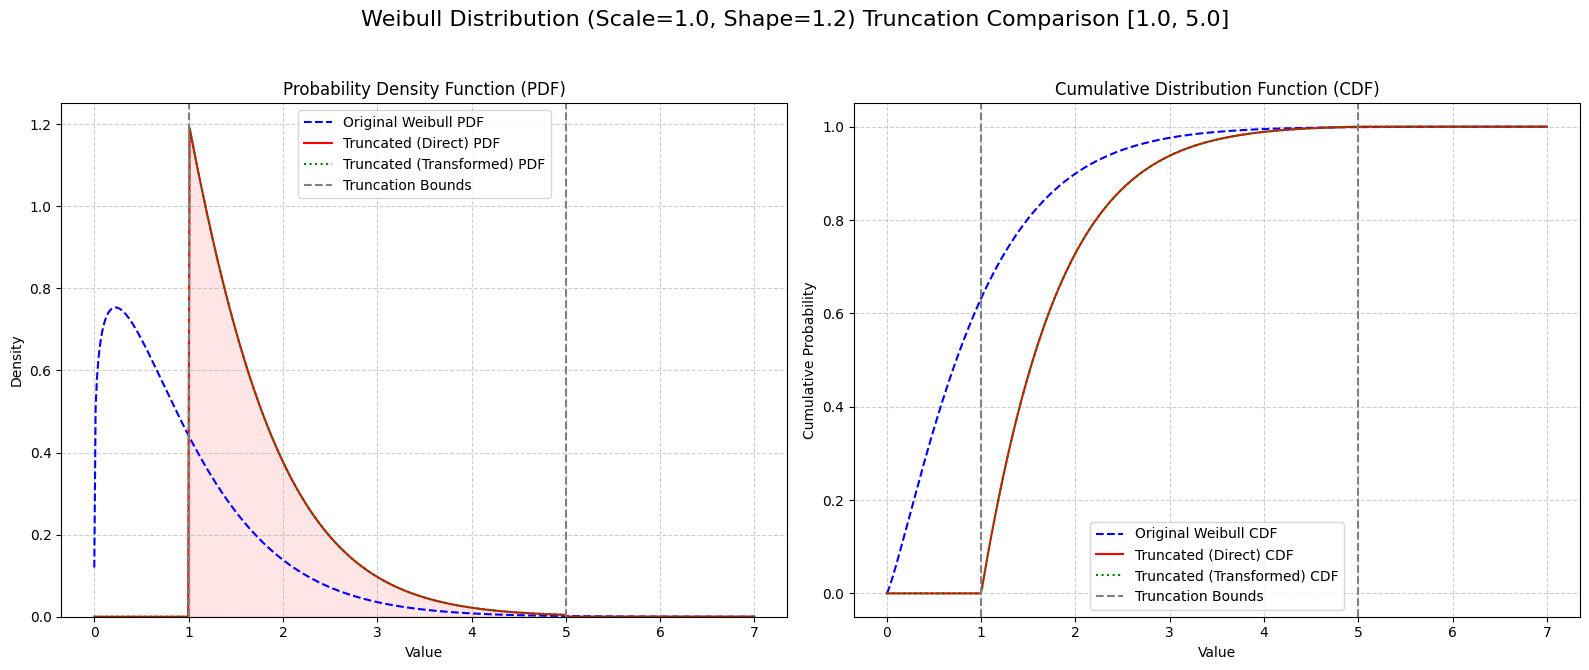


--- Truncation Comparison Summary ---
Original Weibull Distribution: Scale=1.0, Shape=1.2
Truncation Bounds: [1.0, 5.0]

Expected Normalization Constant (P(lower <= X <= upper)): 0.366870
Truncated (Direct) Log Normalization Constant: -1.002747
Truncated (Transformed) Log Interval Probability: -1.002747

--- Sample Comparison (Min/Max values) ---
Truncated (Direct) Samples (1000): Min=1.0008, Max=4.5333
Truncated (Transformed) Samples (1000): Min=1.0004, Max=4.9496


In [36]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 7)) # Increased figure size for better readability
fig.suptitle(f'Weibull Distribution (Scale={scale}, Shape={shape}) Truncation Comparison [{lower_bound_val}, {upper_bound_val}]', fontsize=16)

# PDF Plot
axes[0].plot(x_np, pdf_base_np, label='Original Weibull PDF', color='blue', linestyle='--')
axes[0].plot(x_np, pdf_truncated_direct_np, label='Truncated (Direct) PDF', color='red')
axes[0].plot(x_np, pdf_truncated_transformed_np, label='Truncated (Transformed) PDF', color='green', linestyle=':')
axes[0].axvline(x=lower_bound_val, color='gray', linestyle='--', label='Truncation Bounds')
axes[0].axvline(x=upper_bound_val, color='gray', linestyle='--')
axes[0].fill_between(x_np, 0, pdf_truncated_direct_np, where=(x_np >= lower_bound_val) & (x_np <= upper_bound_val), color='red', alpha=0.1)
axes[0].set_title('Probability Density Function (PDF)')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].set_ylim(bottom=0)

# CDF Plot
axes[1].plot(x_np, cdf_base_np, label='Original Weibull CDF', color='blue', linestyle='--')
axes[1].plot(x_np, cdf_truncated_direct_np, label='Truncated (Direct) CDF', color='red')
axes[1].plot(x_np, cdf_truncated_transformed_np, label='Truncated (Transformed) CDF', color='green', linestyle=':')
axes[1].axvline(x=lower_bound_val, color='gray', linestyle='--', label='Truncation Bounds')
axes[1].axvline(x=upper_bound_val, color='gray', linestyle='--')
axes[1].set_title('Cumulative Distribution Function (CDF)')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Cumulative Probability')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].set_ylim(-0.05, 1.05) # Allow small margin for clarity

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print(f"\n--- Truncation Comparison Summary ---")
print(f"Original Weibull Distribution: Scale={scale}, Shape={shape}")
print(f"Truncation Bounds: [{lower_bound_val}, {upper_bound_val}]")

# Print normalization constants for both implementations (should be similar)
base_cdf_lower = base_weibull.cdf(lower_bound_tensor).item()
base_cdf_upper = base_weibull.cdf(upper_bound_tensor).item()
normalization_value = base_cdf_upper - base_cdf_lower

print(f"\nExpected Normalization Constant (P(lower <= X <= upper)): {normalization_value:.6f}")
print(f"Truncated (Direct) Log Normalization Constant: {truncated_weibull_direct.log_normalization_constant.item():.6f}")
print(f"Truncated (Transformed) Log Interval Probability: {truncated_weibull_transformed.transforms[0].log_interval_prob.item():.6f}")

# Sample from both and compare min/max
print("\n--- Sample Comparison (Min/Max values) ---")
samples_direct = truncated_weibull_direct.sample((1000,))
samples_transformed = truncated_weibull_transformed.sample((1000,))

print(f"Truncated (Direct) Samples (1000): Min={samples_direct.min().item():.4f}, Max={samples_direct.max().item():.4f}")
print(f"Truncated (Transformed) Samples (1000): Min={samples_transformed.min().item():.4f}, Max={samples_transformed.max().item():.4f}")

In [47]:
# calculate integration of the PDF
import numpy as np
area_pdf_base = np.trapezoid(y=pdf_base_np, x=x_np , dx=0.0001)
area_pdf_truncated_direct = np.trapezoid(y=pdf_truncated_direct_np, x=x_np , dx=0.0001)
area_pdf_truncated_transformed = np.trapezoid(y=pdf_truncated_transformed_np, x=x_np , dx=0.0001)
print(f"\nIntegrating PDF base: {area_pdf_base:.6f}")
print(f"\nIntegrating PDF truncated direct: {area_pdf_truncated_direct:.6f}")
print(f"\nIntegrating PDF truncated transformed: {area_pdf_truncated_transformed:.6f}")



Integrating PDF base: 0.998299

Integrating PDF truncated direct: 0.996373

Integrating PDF truncated transformed: 0.996373
